# Machine Learning Engineer Nanodegree
## Capstone Project
Kanja Saha  
January 15, 2018

## I. Definition

### Project Overview
_Build a Product Recommendation Engine with item to item Collaborative Filtering technique using Matrix Factorization_

Some say customer is God and others say customer is King. Some say, "Listen to your customer!" while others say "Know thy customer!". The latter is my personal marketing philosophy!

A company exists because of its customers; to be precise, its loyal customers. 
A loyal customer is a satisfied customer whose trust you have earned. And the word "trust" carries a lot of weight and is only earned through consistent positive value of product, service and experience and show that you "know your customer" . To reflect that you indeed know your customer, it is imperative that you recommend only the products that you believe will benefit the customer. 

Hence a product recommendation engine is crucial for every company’s success. In fact it is necessary for success of every department of the company. A recommender system is already in place for large market place such as Amazon, Google and other organizations, small or large, are inspired to build a near accurate recommender system. As I got introduced to Nearest Neighor Algorithm in Unsupervised Learning in Udacity’s Machine Learning Nanodegree Program, I realized that clustering is at the base of Recommender System. I then researched further to find Collaborative Filtering technique implementing Matrix Factorization to be one of the popular methods to build an efficient recommender engine. 

In the more general sense, collaborative filtering is the process of filtering for information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources, etc. In terms of recommendation system, it is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating) and finding similarities between items based on user feedback. In the mathematical discipline of linear algebra, a matrix decomposition or matrix factorization is a dimensionality reduction technique that factorizes a matrix into a product of matrices, usually two. 

In building Recconmendation System using item to item Collaborative Filtering technique, we generate two matrices through convergence: an user matrix with latent features of the users  and an item matrix with a few latent features of the Items. We then take the item similarity matrix and assign rating to users based on previous ratings of the user on similar items.

I will use Amazon Product Ratings Only  Dataset for this project.
These datasets include no metadata or reviews, but only (user,item,rating,timestamp) tuples. I will use reviewerID(user), asin(item) and overall(rating) columns for my project.

Following are the details on the dataset.

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- overall: rating of the product,
- reviewTime - time of the review (raw)

Sample Ratings Only Data:
{
  "reviewerID": "A2SUAM1J3GNN3B",
  "asin": "0000013714",
  "overall": 5.0,
  "reviewTime": "09 13, 2009"
}

Source for the data: http://jmcauley.ucsd.edu/data/amazon/links.html


Reference:

https://www.quora.com/What-is-a-laymans-explanation-of-matrix-factorization-in-collaborative-filtering
http://vcp.med.harvard.edu/papers/matrices-3.pdf
http://mahout.apache.org/users/recommender/matrix-factorization.html

### Problem Statement

With the advent of internet commerce, it has become convenient for the users to find the items of their interest without stepping out of their house. However with the consistent  increase of number of online retailers it is also very difficult for the user to find the items that really meets their need the best. Users feel lost in the sea of products available to them and often fear of making a wrong purchasing decision. And once they make a purchase that is not ideal, customers shy away from making further online purchase investment or recommending others. This is a no win situation for the user as well as the company selling the product

Recommendation system is considered a semi supervised learning or a combination of supervised(ranking a recommended item) and unsupervised learning(forming clusters of similar groups of customers/items). But overall it is an information retrieval system, which is another large area of machine learning.

To make a buyer feel confident about making frequent purchase decision, there is a need for a system which learns the user preferences, spending pattern and generate recommendations based on his interest and past buying habit, The Recommender System. I believe, one of the best ways to build the recommendation engine is by using Collaborative Filtering technique. Collaborative filtering is the technique of recommending items to users based on past interactions between users and items. 

So, my goal is to build a recommendation system with item to item Collaborative Filtering Technique. I will implement the Matrix Factorization algorithms in sklearn Library: Non-Negative Matrix Factorization.


### Metrics

I will use Root Mean Square Error (RMSE) as evaluation metrics.

Root mean squared error (RMSE): RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

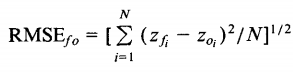

where n is the total number of observations, and Z(fi) and Z(oi) are forcasted and observed values of an observation i.

Reference:

http://www.statisticshowto.com/rmse/
https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d


## II. Analysis

### Data Exploration & Visualization

Amazon ratings source dataset has around 82.5 million rows and 4 columns. The first three columns, reviewerID, asin and overall are required for this project. The dataset has 21,176,522 unique reviewers and 9,874,211 items. <br>

Due to limitation of my personal computer performance as well as more accuracy. The final dataset of 10 million rows and 3 columns consist of a set of 576,489 reviewers who have rated atleast 20 items as well 112,980 items that are rated by atleast 100 reviewers.<br>
This filtered dataset does not have any null values.

In [ ]:
### Load Libraries and Dataset
import pandas as pd
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt;
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from IPython.display import display
import itertools


#raw_data= pd.read_csv("item_dedup.csv", skiprows=2000000,nrows=1000000, header=None)
raw_data_step1= pd.read_csv("item_dedup.csv", nrows=7000000, header=None)
raw_data_step1.columns = ['reviewerID', 'asin','overall','reviewTime']
raw_data_step1.drop(['reviewTime'], axis = 1, inplace = True)

raw_data=raw_data_step1.assign(rnk=raw_data_step1.groupby(['overall'])['asin']
                    .rank(method='min', ascending=False)) .query('rnk < 500000') 
raw_data.drop(['rnk'], axis = 1, inplace = True)

display(raw_data.shape)
#raw_data.isnull().any()
raw_data.head()

sns.set(color_codes=True)
plt.figure('overall')
plt.ylabel('Count of Ratings')
plt.xlabel('Ratings 1 to 5')
sns.distplot(raw_data['overall'])
plt.show()

In [ ]:
# Generate Subset of the data

item_rating_count=raw_data.groupby('asin').aggregate({'reviewerID': np.count_nonzero})
item_rating_count_gte_200 = item_rating_count[item_rating_count.reviewerID > 200]

asin_rating_count_gte_200=item_rating_count_gte_200.index

shortlisted_data = raw_data[raw_data.asin.isin(asin_rating_count_gte_200)]

final_data=shortlisted_data.assign(rnk=shortlisted_data.groupby(['asin'])['reviewerID']
                    .rank(method='min', ascending=False)) .query('rnk < 25') 
final_data.drop(['rnk'], axis = 1, inplace = True)

display(final_data.isnull().any())
display(final_data.shape)
display(final_data.nunique())
final_data.head()


### Exploratory Visualization

The count of items for each ratings in the dataset is obtained and the graph is plotted as shown below in Figure 1. From the graph it is obvious that users have mostly rated items as 4 or 5, which is a good news because this implies there is high potential for product recommendation of similar items.
About 50% of all ratings are 5, 30% of all ratings are 4, 5% are 3 and the rest are 1 and 2.

In [ ]:
# Rating and its count
sns.set(color_codes=True)
plt.figure('overall')
plt.ylabel('Count of Ratings')
plt.xlabel('Ratings 1 to 5')
sns.distplot(final_data['overall'])
plt.show()

display(final_data['overall'].describe([.1,.15,.2,.3,.4,.5,.6,.7,.8,.9]).apply(lambda x: '%.0f' % x))


### Algorithms and Techniques

I will use Non-Negative Matrix Factorization (NMF) model which is implemented in sklearn library in Python.<br> 

Non-Negative Matrix Factorization (NMF) is a recent technique for linear dimensionality reduction and data analysis that yields a parts based, sparse non-negative representation for non-negative input data. Essentialy, NMF is an unsupervised learning algorithm coming from linear algebra that not only reduces data dimensionality, but also performs clustering simultaneously.<br>

70% of the items in this dataset has receieved rating from .05% of total reviewers, this can be considered a sparse matrix. NMF tend to perform better than SVD and other matrix factorization alogorithms for sparse matrix. <br>

NMF finds two non-negative matrices (W, H) whose product approximates the original non- negative matrix X.<br>

NMF has quite a few parameters but the most deciding factor is n_components, an integer or none.
n_components is the total number of latest features of the factored Matrices. The optimum value for n_components  can be generated by implementing NMF model in iterative fashion with different n_components and generate the RMSE value for each value of n_components in NMF. The n_components(latent features) with least RMSE score will be used to find the RMSE score in test dataset.

The parameters and attribute of NMF in sklearn are noted as below:
class sklearn.decomposition.NMF(n_components=None, init=None, solver='cd', beta_loss='frobenius', tol=0.0001, max_iter=200, random_state=None, alpha=0.0, l1_ratio=0.0, verbose=0, shuffle=False)

The details of this class and its default parameters can be found in sklearn documentation.<br>
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html<br>



In [ ]:
display(item_rating_count_gte_200['reviewerID'].describe([.1,.15,.2,.3,.4,.5,.6,.7,.8,.9]).apply(lambda x: '%.0f' % x))


### Benchmark

I will use nearest neighors algorithm in sklearn library to generate the benchmark numbers.

The benchmark score for RMSE is 4 with k neighors and are generated by implementing nearest neighors algorithm in the Methodology/Implementation Section.

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
The final dataset is pivoted to create a sparse dataframe with "reviewerID" as Index, "asin" as Column and "overall" as value. <br>This final dataframe has n rows(reviewers) and n columns(items).

We then split this dataframe into train and test dataset(20% for testing). 10 fold validation will be performed on training dataset to find the optimum k value for k neighors algorithm and optimum p latent features for Non Negative Matrix Factorization based on their RMSE and MAE scores.

These k and p values will then be used on test dataset for kneighors and NMF algorithm. The RMSE and MAE score from kneighors is will be considered as baseline and will be used as benchmark to compare the performance of NMF algorithm based on the metrics.

In [ ]:
# Preprocessing Data
#final_data=raw_data
pivot_data=pd.pivot_table(final_data, values = 'overall', index='reviewerID', columns ='asin')
pivot_data.fillna(0, inplace=True)
display(pivot_data.shape)

train_data, test_data = train_test_split(pivot_data, test_size=0.2)

display(train_data.head())
test_data.head()



In [ ]:
cols = train_data.columns
bt = train_data.apply(lambda x: x > 1)
bt.apply(lambda x: list(cols[x.values]), axis=1)


### Implementation
* Programming Language: Python 3.6
* Libraries : Pandas,Numpy, Scikit-learn
* Goal: Implement NMF in sklearn to build a recommender system using item to item collaborative filtering technique
* Workflow :
    * Establish the baselines with K-nearest neighbors for comparison.


In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

In [ ]:
#Functions

def join_groundtruth_predicted_value(v_item_similarity,v_raw_data,v_data):
    
    item_prediction = v_data.dot(v_item_similarity) /((v_item_similarity).sum(axis=1))
        
    item_prediction['reviewerID']=item_prediction.index
    prediction_melt=pd.melt(item_prediction, id_vars=['reviewerID'], var_name='asin', value_name='overall_pred')
     
    final=pd.merge(v_raw_data, prediction_melt, how='inner', on=['reviewerID','asin'])
    return final



def get_item_similarity_knn(v_data,v_i):
    v_data_t=v_data.transpose()
    model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute',n_neighbors=v_i)
    model_knn.fit(v_data_t)
    itemtoitem_1=model_knn.kneighbors_graph(v_data_t)
    itemtoitem=itemtoitem_1.toarray()
    item_similarity=pd.DataFrame(itemtoitem, columns=v_data.columns,index=v_data.columns)
   
    return item_similarity
    

In [ ]:
n_neighbors_approx=np.floor(sqrt(train_data.shape[1])).astype(np.int64) 
neighors=range(1,n_neighbors_approx+8)
RMSE_score = []
    
for i in neighors:
    
        item_similarity_knn=get_item_similarity_knn(train_data,i)
        final=join_groundtruth_predicted_value(item_similarity_knn,raw_data,train_data)
        rmse=sqrt(mean_squared_error(final.overall_pred, final.overall))
                    
        RMSE_score.append(rmse)
        print ('Item-based CF RMSE for Training Set: ' + str(rmse) + ' for ' + str(i) + ' neighors')
    
neighors_list=(list(neighors))
plt.plot(neighors_list, RMSE_score)
plt.xlabel('Number of Neighbors K')
plt.ylabel('RMSE')
plt.show()     

In [ ]:
#NMF

def join_groundtruth_predicted_value_NF(nmf,v_raw_data,v_data,v_i):
    
    W = nmf.transform(v_data);
    H = nmf.components_
    item_prediction_NF = np.dot(W,H)

    item_prediction_NF=pd.DataFrame(item_prediction_NF, columns=v_data.columns,index=v_data.index)
    
    item_prediction_NF['reviewerID']=item_prediction_NF.index
    prediction_melt=pd.melt(item_prediction_NF, id_vars=['reviewerID'], var_name='asin', value_name='overall_pred')
     
    final=pd.merge(v_raw_data, prediction_melt, how='inner', on=['reviewerID','asin'])
    return final

In [ ]:
latent_features=range(100,500,100)
alpha_values=(x * 0.001 for x in range(0, 10,5))
l1_ratio_values=(x * 0.01 for x in range(0, 10,5))
RMSE_nf_score = []
combo=[]
import itertools
for combination in itertools.product(latent_features, alpha_values, l1_ratio_values):
    i=combination[0]
    a=combination[1]
    l1=combination[2]

    nmf = NMF(n_components =i,alpha=a,l1_ratio=l1)
    W = nmf.fit(train_data);
    final=join_groundtruth_predicted_value_NF(nmf,raw_data,train_data,i)
    rmse_nf=sqrt(mean_squared_error(final.overall_pred, final.overall))
    combo.append(i)
    RMSE_nf_score.append(rmse_nf)
    print ('Item-based CF RMSE: ' + str(rmse_nf) + ' for ' + str(i) + ' latent features, '+ str(a) + ' alpha, '+ str(l1) + ' l1_ratio')
           

latent_features_list=(list(combo))
plt.plot(latent_features_list, RMSE_nf_score)
plt.xlabel('Number of Latest Features P')
plt.ylabel('RMSE')
plt.show()



### Refinement

I initially chose the k neighors based on the sqroot of the total number of samples. I then decided to iterate over 20 values around k to find the minimum RMSE scores. The K respect to the minimum RMSE value is then choses as the final K neighors.

In case of NMF, I started with 2 latent features and then iterated over 40 consecutive p values find the minimum RMSE scores. The K respect to the minimum RMSE value is then chosen as the final p latent factor.


## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation

The k neighors and p latent factors are obtained from the training dataset.

We then use the optimized parameters and implement the models with test dataset.

The RMSE score for KNN in th etest dataset with k neighors is 3
The RMSE score for the NMF dataset with p latent factors is 2. 


In [ ]:
k=32
        
item_similarity_knn=get_item_similarity_knn(train_data,k)
final=join_groundtruth_predicted_value(item_similarity_knn,raw_data,test_data)
rmse=sqrt(mean_squared_error(final.overall_pred.astype(int), final.overall.astype(int)))

                  
print ('Item-based CF RMSE for Test Set using knn: ' + str(rmse) + ' for ' + str(k) + ' neighors')

In [ ]:
p=300
nmf = NMF(n_components =p,alpha=0,l1_ratio=0)
W = nmf.fit(train_data);
final_nf=join_groundtruth_predicted_value_NF(nmf,raw_data,test_data,p)
rmse_nf = sqrt(mean_squared_error(final_nf.overall_pred, final_nf.overall))
print ('Item-based CF RMSE for Test Set using NF: ' + str(rmse_nf) + ' for ' + str(p) + ' latent features')
   

In [ ]:
brand_new_data_step1= pd.read_csv("item_dedup.csv", skiprows=7000000,nrows=1000000, header=None)
brand_new_data_step1.columns = ['reviewerID', 'asin','overall','reviewTime']
brand_new_data_step1.drop(['reviewTime'], axis = 1, inplace = True)

brand_new_data=brand_new_data_step1.assign(rnk=brand_new_data_step1.groupby(['overall'])['asin']
                    .rank(method='min', ascending=False)) .query('rnk < 100000') 
brand_new_data.append(final_data)
brand_new_data.drop(['rnk'], axis = 1, inplace = True)

brand_new_data_pivot=pd.pivot_table(brand_new_data, values = 'overall', index='reviewerID', columns ='asin')
brand_new_data_pivot.fillna(0, inplace=True)



p=300
a=0
l1=0
nmf = NMF(n_components =p, random_state=r,alpha=a,l1_ratio=l1)
W = nmf.fit(brand_new_data_pivot);
final_nf=join_groundtruth_predicted_value_NF(nmf,brand_new_data,brand_new_data_pivot,p)
rmse_nf = sqrt(mean_squared_error(final_nf.overall_pred, final_nf.overall))
print ('Item-based CF RMSE for Test Set using NF: ' + str(rmse_nf) + ' for ' + str(p) + ' latent features')
   

In [ ]:
p=300
r_state=range(43,600,30)
rmse_r_state=[]
for r in r_state:
    nmf = NMF(n_components =p, random_state=r,alpha=a,l1_ratio=l1)
    W = nmf.fit(train_data);
    final_nf=join_groundtruth_predicted_value_NF(nmf,raw_data,test_data,p)
    rmse_nf = sqrt(mean_squared_error(final_nf.overall_pred, final_nf.overall))
    rmse_r_state.append(rmse_nf)
    print ('Item-based CF RMSE for Test Set using NF: ' + str(rmse_nf) + ' for ' + str(p) + ' neighors')
   

r_state_list=(list(r_state))
plt.plot(r_state_list, rmse_r_state)
plt.xlabel('Random State with latent features 300')
plt.ylabel('RMSE')
plt.show()

from statistics import mean,variance
mean=mean(rmse_r_state)
var=variance(rmse_r_state)
mean,'{:f}'.format(var)

In [ ]:
p=300
r_state=range(43,600,30)
rmse_r_state=[]
for r in r_state:
    nmf = NMF(n_components =p, random_state=r)
    W = nmf.fit(train_data);
    final_nf=join_groundtruth_predicted_value_NF(nmf,raw_data,test_data,p)
    rmse_nf = sqrt(mean_squared_error(final_nf.overall_pred, final_nf.overall))
    rmse_r_state.append(rmse_nf)
    print ('Item-based CF RMSE for Test Set using NF: ' + str(rmse_nf) + ' for ' + str(p) + ' neighors')
   

r_state_list=(list(r_state))
plt.plot(r_state_list, rmse_r_state)
plt.xlabel('Random State with latent features 300')
plt.ylabel('RMSE')
plt.show()

from statistics import mean,variance
mean=mean(rmse_r_state)
var=variance(rmse_r_state)
mean,'{:f}'.format(var)

### Justification

The results obtained are reasonalbly good buy further improvement can be done.

Comparing our results with those in our Benchmark  RMSE score in KNN, we can say that the RMSE score has improved significantly for our NMF Model.

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization

The charts below visualizes the prediction accuracy of the KNN and NMF dataset and compares it visually with the original dataset.

We also add the predicted rating of the unrated items.

In [ ]:
sns.set(color_codes=True)
plt.figure('overall')
plt.ylabel('Count of Ratings')
plt.xlabel('Ratings 1 to 5')
sns.distplot(final['overall'])
plt.show()


sns.set(color_codes=True)
plt.figure('overall')
plt.ylabel('Count of Ratings')
plt.xlabel('Ratings 1 to 5')
sns.distplot(final['overall_pred'])
plt.show()

sns.set(color_codes=True)
plt.figure('overall')
plt.ylabel('Count of Ratings')
plt.xlabel('Ratings 1 to 5')
sns.distplot(final_nf['overall_pred'])
plt.show()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
### Reflection
The Udacity ML Nanodegree Capstone Project has been a challenging yet enriching experience. Each section has been challenging in its way but implementation section has been the most challenging for me. Besides handling 82 milion dataset and reducing it down to a reasonable number that my PC can handle has been a time consuming process as well.


### Improvement

There are several ways the model can be improved, given more time and more powerful Server:

1. Value of k in k neighors and p latent factors in NMF can be optimized by by implementing K fold cross validation. BY splitting the dataset in K folds and then choosing random K-1 folds at a time, K RMSE scores can be generated for a specific k or p values. The k/p value with the lowest average RMSE score can then be marked as optimized and used in the final dataset.

2. A few other We can also try a few other matrix factorization algorithm such as SVD and bench mark the performance as well.

Since I have have the timestamp for each review, I can use recurrent neural network to provide session based recommendation which will give recommendation on immediate products the user might be interested in.